<a href="https://colab.research.google.com/github/mahault/Quantum-C/blob/main/Quantum_computing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.0/930.0 kB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 32.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 30.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 48.2 MB/s eta 0:00:00


In [ ]:
import pennylane as qml
import numpy as np
from pennylane.optimize import AdamOptimizer

# Define quantum device
dev = qml.device("default.qubit", wires=2)

# Define VQC
def circuit(params, x):
    # Data embedding
    qml.RY(x[0], wires=0)
    qml.RY(x[1], wires=1)
    # Parameterized gates
    qml.RY(params[0], wires=0)
    qml.RY(params[1], wires=1)
    # Entanglement layer
    qml.CNOT(wires=[0, 1])

@qml.qnode(dev)
def quantum_model(params, x):
    circuit(params, x)
    return qml.expval(qml.PauliZ(0))

# Loss function
def loss(params, X, y):
    loss = 0
    for x_i, y_i in zip(X, y):
        pred = quantum_model(params, x_i)
        loss += (pred - y_i) ** 2
    return loss / len(X)

# Training data
X = np.array([[0.1, 0.2], [0.4, 0.3], [1.0, 1.1], [0.9, 1.2]])
y = np.array([0, 0, 1, 1])

# Initialize parameters
params = np.random.random(2)

# Train the model
opt = AdamOptimizer(stepsize=0.1)
for i in range(50):
    params = opt.step(lambda v: loss(v, X, y), params)

print("Trained Parameters:", params)


/usr/local/lib/python3.10/dist-packages/pennylane/_grad.py:216: UserWarning: Attempted to differentiate a function with no trainable parameters. If this is unintended, please add trainable parameters via the 'requires_grad' attribute or 'argnum' keyword.
  warnings.warn(


Trained Parameters: [0.25321642 0.39396032]


Variational Inference

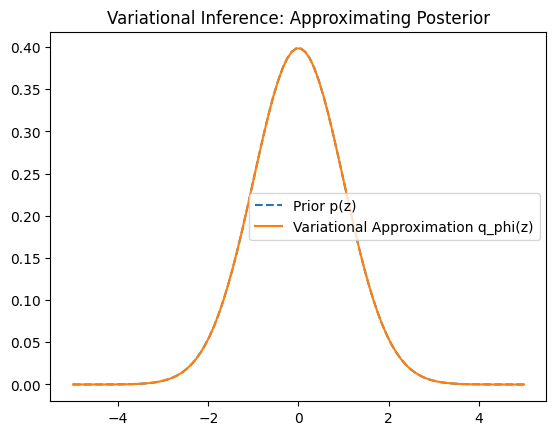

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Observed data (x)
x = np.random.normal(loc=2, scale=1, size=100)

# Variational parameters for approximating q_phi(z)
phi_mean = 0.0
phi_std = 1.0

# True prior for z (e.g., standard normal)
z = np.linspace(-5, 5, 100)
prior = norm.pdf(z, loc=0, scale=1)

# Variational approximation
q_phi = norm.pdf(z, loc=phi_mean, scale=phi_std)

# Plot
plt.plot(z, prior, label="Prior p(z)", linestyle="--")
plt.plot(z, q_phi, label="Variational Approximation q_phi(z)")
plt.title("Variational Inference: Approximating Posterior")
plt.legend()
plt.show()


Mix of both

In [ ]:
import pennylane as qml
import numpy as np
from pennylane.optimize import AdamOptimizer

# Set up a quantum device
dev = qml.device("default.qubit", wires=1)

# Variational quantum circuit representing q_phi(z)
@qml.qnode(dev)
def variational_circuit(params):
    """
    Quantum circuit to represent the variational distribution q_phi(z).
    """
    qml.RY(params[0], wires=0)  # Rotation on Y-axis parameterized by params[0]
    qml.RZ(params[1], wires=0)  # Rotation on Z-axis parameterized by params[1]
    return qml.probs(wires=0)   # Return probabilities for |0⟩ and |1⟩

# Prior distribution p(z)
def prior_distribution(z):
    """
    Simple prior distribution p(z).
    Assume a uniform distribution for this example: p(z=0) = 0.5, p(z=1) = 0.5.
    """
    return 0.5  # Uniform prior

# Likelihood p(x|z)
def likelihood(x, z):
    """
    Likelihood function p(x|z).
    Assume class-dependent likelihood for simplicity.
    """
    if z == 0:
        return np.exp(-np.linalg.norm(x - np.array([0.5, 0.5])))  # Class 0
    else:
        return np.exp(-np.linalg.norm(x - np.array([1.5, 1.5])))  # Class 1

# ELBO (Evidence Lower Bound)
def elbo_loss(params, x):
    """
    Compute the ELBO using q_phi(z), p(z), and p(x|z).
    """
    # Generate q_phi(z) using the variational circuit
    q_phi = variational_circuit(params)  # This will return [q_phi(z=0), q_phi(z=1)]

    # Compute the likelihood p(x|z) for each possible z
    likelihood_z0 = likelihood(x, 0)
    likelihood_z1 = likelihood(x, 1)

    # Compute the prior p(z)
    prior_z0 = prior_distribution(0)
    prior_z1 = prior_distribution(1)

    # Compute KL divergence term
    kl_div = q_phi[0] * np.log(q_phi[0] / prior_z0) + q_phi[1] * np.log(q_phi[1] / prior_z1)

    # Compute expected log likelihood
    expected_log_likelihood = q_phi[0] * np.log(likelihood_z0) + q_phi[1] * np.log(likelihood_z1)

    # ELBO = Expected Log Likelihood - KL Divergence
    return -(expected_log_likelihood - kl_div)  # Negative for minimization

# Training data
X = np.array([[0.5, 0.5], [1.5, 1.5]])  # Example data points
params = np.random.random(2)  # Initialize parameters for the quantum circuit

# Optimizer
opt = AdamOptimizer(stepsize=0.1)

# Training loop
for step in range(50):
    loss = 0
    for x in X:
        loss += elbo_loss(params, x)  # Accumulate ELBO loss for all data points
    loss /= len(X)  # Average loss over dataset

    # Update parameters using the optimizer
    params = opt.step(lambda v: np.mean([elbo_loss(v, x) for x in X]), params)

    if step % 10 == 0:
        print(f"Step {step}: Loss = {loss:.4f}")

# Output trained parameters
print("Trained Parameters:", params)

# Final q_phi(z)
final_probs = variational_circuit(params)
print("Final q_phi(z):", final_probs)


Step 0: Loss = 1.0361
Step 10: Loss = 1.0361
Step 20: Loss = 1.0361
Step 30: Loss = 1.0361
Step 40: Loss = 1.0361
Trained Parameters: [0.70322983 0.15144208]
Final q_phi(z): [0.88137874 0.11862126]


In [ ]:
import pennylane as qml
import numpy as np

# Quantum device setup
dev = qml.device("default.qubit", wires=1)

# Variational quantum circuit
@qml.qnode(dev)
def quantum_circuit(theta):
    """
    Quantum circuit that produces a superposition state, parameterized by theta.
    theta controls the rotation of the qubit.
    """
    qml.RY(theta, wires=0)  # Rotation around Y-axis by theta
    return qml.probs(wires=0)  # Return probabilities for |0⟩ and |1⟩

# Variational distribution q_phi
def q_phi(phi):
    """
    Variational distribution q_phi(|z⟩), parameterized by phi.
    P(|0⟩) = phi, P(|1⟩) = 1 - phi.
    """
    return np.array([phi, 1 - phi])

# Posterior distribution P(|z⟩ | data)
def posterior(data):
    """
    Define the target posterior distribution based on the observed data.
    """
    return np.array(data)  # Example posterior probabilities

# KL divergence
def kl_divergence(q, p):
    """
    Compute the KL divergence between q_phi(|z⟩) and P(|z⟩ | data).
    """
    return np.sum(q * np.log(q / p))

# Loss function (variational inference with quantum circuit)
def elbo_loss(phi, data, num_samples=10):
    """
    Compute the ELBO loss for the variational distribution q_phi(|z⟩).
    """
    # Compute the variational distribution q_phi
    q = q_phi(phi)

    # Compute the posterior distribution P(|z⟩ | data)
    p = posterior(data)

    # Compute KL divergence term
    kl = kl_divergence(q, p)

    # Compute likelihood term using the quantum circuit
    likelihood = 0
    for _ in range(num_samples):
        # Sample theta from q_phi(|z⟩)
        theta = np.arccos(np.sqrt(q[0])) * 2  # Convert probabilities to theta
        circuit_probs = quantum_circuit(theta)
        likelihood += circuit_probs[0] * np.log(p[0]) + circuit_probs[1] * np.log(p[1])
    likelihood /= num_samples

    # ELBO = Expected Log Likelihood - KL Divergence
    return -(likelihood - kl)

# Optimization loop
def optimize(data, phi_init=0.5, learning_rate=0.1, steps=50):
    """
    Optimize the variational parameter phi to approximate the quantum state probabilities.
    """
    phi = phi_init  # Initialize variational parameter

    for step in range(steps):
        # Compute loss
        loss = elbo_loss(phi, data)

        # Compute gradient (approximation via finite difference)
        grad = (elbo_loss(phi + 1e-5, data) - elbo_loss(phi - 1e-5, data)) / (2e-5)

        # Update phi using gradient descent
        phi -= learning_rate * grad

        # Clip phi to ensure valid probabilities
        phi = max(0, min(1, phi))

        if step % 10 == 0 or step == steps - 1:
            print(f"Step {step}: Loss = {loss:.4f}, phi = {phi:.4f}")

    # Return optimized variational parameter and final distribution
    return phi, q_phi(phi)

# Example usage
if __name__ == "__main__":
    # Target posterior distribution
    data = [0.8, 0.2]  # P(|0⟩) = 0.8, P(|1⟩) = 0.2

    # Optimize the variational distribution
    phi_final, q_final = optimize(data, phi_init=0.5, learning_rate=0.1, steps=50)

    print("\nFinal Variational Distribution:")
    print(f"phi = {phi_final:.4f}")
    print(f"q_phi(|z⟩) = {q_final}")

# Function to predict the class of a new data point
def predict(data_point, phi, class_centers):
    """
    Predict the class of a new data point using the trained variational distribution q_phi.
    """
    # Compute the posterior distribution for the new data point
    p = posterior(data_point, class_centers)

    # Compute the variational distribution q_phi(|z⟩)
    q = q_phi(phi)

    # Compare q_phi and posterior to make a prediction
    predicted_class = np.argmax(q)  # Class with highest probability
    return predicted_class, q

# Example usage: Predicting a new data point
new_data_point = np.array([0.15, 0.25])  # Example test data
predicted_class, predicted_probs = predict(new_data_point, phi_final, class_centers)

print(f"New Data Point: {new_data_point}")
print(f"Predicted Class: {predicted_class}")
print(f"Predicted Probabilities: {predicted_probs}")



Step 0: Loss = 1.1394, phi = 0.7773
Step 10: Loss = 0.3857, phi = 0.9426
Step 20: Loss = 0.3857, phi = 0.9413
Step 30: Loss = 0.3857, phi = 0.9412
Step 40: Loss = 0.3857, phi = 0.9412
Step 49: Loss = 0.3857, phi = 0.9412

Final Variational Distribution:
phi = 0.9412
q_phi(|z⟩) = [0.94117614 0.05882386]


NameError: name 'class_centers' is not defined

In [ ]:
import pennylane as qml
import numpy as np

# Quantum device setup
dev = qml.device("default.qubit", wires=1)

# Quantum circuit
@qml.qnode(dev)
def quantum_circuit(theta):
    """
    Quantum circuit that produces a superposition state, parameterized by theta.
    """
    qml.RY(theta, wires=0)  # Rotate qubit on Y-axis
    return qml.probs(wires=0)  # Output probabilities for |0\u27e8 and |1\u27e8

# Variational distribution q_phi
def q_phi(phi):
    """
    Variational distribution q_phi(|z\u27e8), parameterized by phi.
    P(|0\u27e8) = phi, P(|1\u27e8) = 1 - phi.
    """
    return np.array([phi, 1 - phi])

# Posterior distribution based on data point
def posterior(data_point, class_centers):
    """
    Posterior distribution P(|z\u27e8 | data).
    Assumes a Gaussian likelihood for each class center.
    """
    distances = [np.linalg.norm(data_point - center) for center in class_centers]
    probabilities = np.exp(-np.array(distances))  # Gaussian likelihood
    return probabilities / np.sum(probabilities)  # Normalize to sum to 1

# KL divergence
def kl_divergence(q, p):
    """
    Compute the KL divergence between q_phi(|z\u27e8) and P(|z\u27e8 | data).
    """
    return np.sum(q * np.log(q / p))

# ELBO loss with data-specific phi
def elbo_loss(phi, data_point, class_centers, lambda_weight=0.7, num_samples=10):
    """
    Compute the ELBO loss for the variational distribution q_phi(|z⟩).
    """
    # Compute the variational distribution q_phi
    q = q_phi(phi)

    # Compute the posterior distribution P(|z⟩ | data)
    p = posterior(data_point, class_centers)

    # Compute KL divergence term
    kl = kl_divergence(q, p)

    # Compute likelihood term using the quantum circuit
    likelihood = 0
    for _ in range(num_samples):
        theta = np.arccos(np.sqrt(q[0])) * 2  # Map probabilities to theta
        circuit_probs = quantum_circuit(theta)
        likelihood += circuit_probs[0] * np.log(p[0]) + circuit_probs[1] * np.log(p[1])
    likelihood /= num_samples

    # Weighted ELBO
    return -(lambda_weight * likelihood - (1 - lambda_weight) * kl)

# Optimization loop with data-specific phi
def optimize_per_data_point(data, class_centers, phi_init=0.5, learning_rate=0.1, steps=50):
    """
    Optimize a separate phi for each data point.
    """
    # Initialize a separate phi for each data point
    phi = np.full(len(data), phi_init)

    for step in range(steps):
        total_loss = 0

        for i, data_point in enumerate(data):
            # Compute loss for the current data point
            loss = elbo_loss(phi[i], data_point, class_centers)
            total_loss += loss

            # Compute gradient (finite difference)
            grad = (elbo_loss(phi[i] + 1e-5, data_point, class_centers) -
                    elbo_loss(phi[i] - 1e-5, data_point, class_centers)) / (2e-5)

            # Update phi for the current data point
            phi[i] -= learning_rate * grad
            phi[i] = max(0, min(1, phi[i]))  # Ensure phi remains valid

        total_loss /= len(data)  # Average loss over all data points

        if step % 10 == 0 or step == steps - 1:
            print(f"Step {step}: Total Loss = {total_loss:.4f}")

    return phi



# Prediction function
def predict(data_point, phi, class_centers):
    """
    Predict the class of a new data point using the trained variational distribution q_phi.
    """
    # Compute the posterior distribution for the new data point
    p = posterior(data_point, class_centers)

    # Compute the variational distribution q_phi(|z\u27e8)
    q = q_phi(phi)

    # Compare q_phi and posterior to make a prediction
    predicted_class = np.argmax(q)  # Class with highest probability
    return predicted_class, q

# Updated main script
if __name__ == "__main__":
    # Training
    phi_final = optimize_per_data_point(X_train, class_centers, phi_init=0.5, learning_rate=0.1, steps=50)

    # Display results
    for i, phi in enumerate(phi_final):
        print(f"Data Point {i + 1}: phi = {phi:.4f}")

    # Testing
    for i, test_point in enumerate(X_test):
        predicted_class, predicted_probs = predict_dynamic(test_point, class_centers)
        print(f"\nTest Point {i + 1}: {test_point}")
        print(f"Predicted Class: {predicted_class}")
        print(f"Predicted Probabilities: {predicted_probs}")

Step 0: Loss = 0.8475, phi = 0.6697
Step 10: Loss = 1.1293, phi = 0.8451
Step 20: Loss = 1.1293, phi = 0.8451
Step 30: Loss = 1.1293, phi = 0.8451
Step 40: Loss = 1.1293, phi = 0.8451
Step 49: Loss = 1.1293, phi = 0.8451

Final Variational Distribution:
phi = 0.8451
q_phi(|z⟩) = [0.84514988 0.15485012]

Test Point 1: [0.15 0.25]
Predicted Class: 0
Predicted Probabilities: [0.84514988 0.15485012]

Test Point 2: [0.85 0.85]
Predicted Class: 0
Predicted Probabilities: [0.84514988 0.15485012]


Meh, let's try it differently

In [ ]:
import pennylane as qml
import numpy as np

# Quantum device setup
dev = qml.device("default.qubit", wires=1)

# Quantum circuit
@qml.qnode(dev)
def quantum_circuit(theta):
    """
    Quantum circuit that produces a superposition state, parameterized by theta.
    """
    qml.RY(theta, wires=0)  # Rotate qubit on Y-axis
    return qml.probs(wires=0)  # Output probabilities for |0⟨ and |1⟨

# Variational distribution q_phi
def q_phi(phi):
    """
    Variational distribution q_phi(|z⟨), parameterized by phi.
    P(|0⟨) = phi, P(|1⟨) = 1 - phi.
    """
    return np.array([phi, 1 - phi])

# Posterior distribution based on data point
def posterior(data_point, class_centers):
    """
    Posterior distribution P(|z⟨ | data).
    Assumes a Gaussian likelihood for each class center.
    """
    distances = [np.linalg.norm(data_point - center) for center in class_centers]
    probabilities = np.exp(-np.array(distances))  # Gaussian likelihood
    return probabilities / np.sum(probabilities)  # Normalize to sum to 1

# KL divergence
def kl_divergence(q, p):
    """
    Compute the KL divergence between q_phi(|z⟨) and P(|z⟨ | data).
    """
    return np.sum(q * np.log(q / p))

# ELBO loss with data-specific phi
def elbo_loss(phi, data_point, class_centers, lambda_weight=0.7, num_samples=10):
    """
    Compute the ELBO loss for the variational distribution q_phi(|z⟨).
    """
    # Compute the variational distribution q_phi
    q = q_phi(phi)

    # Compute the posterior distribution P(|z⟨ | data)
    p = posterior(data_point, class_centers)

    # Compute KL divergence term
    kl = kl_divergence(q, p)

    # Compute likelihood term using the quantum circuit
    likelihood = 0
    for _ in range(num_samples):
        theta = np.arccos(np.sqrt(q[0])) * 2  # Map probabilities to theta
        circuit_probs = quantum_circuit(theta)
        likelihood += circuit_probs[0] * np.log(p[0]) + circuit_probs[1] * np.log(p[1])
    likelihood /= num_samples

    # Weighted ELBO
    return -(lambda_weight * likelihood - (1 - lambda_weight) * kl)

# Optimization loop with data-specific phi
def optimize_per_data_point(data, class_centers, phi_init=0.5, learning_rate=0.1, steps=50):
    """
    Optimize a separate phi for each data point.
    """
    # Initialize a separate phi for each data point
    phi = np.full(len(data), phi_init)

    for step in range(steps):
        total_loss = 0

        for i, data_point in enumerate(data):
            # Compute loss for the current data point
            loss = elbo_loss(phi[i], data_point, class_centers)
            total_loss += loss

            # Compute gradient (finite difference)
            grad = (elbo_loss(phi[i] + 1e-5, data_point, class_centers) -
                    elbo_loss(phi[i] - 1e-5, data_point, class_centers)) / (2e-5)

            # Update phi for the current data point
            phi[i] -= learning_rate * grad
            phi[i] = max(0, min(1, phi[i]))  # Ensure phi remains valid

        total_loss /= len(data)  # Average loss over all data points

        if step % 10 == 0 or step == steps - 1:
            print(f"Step {step}: Total Loss = {total_loss:.4f}")

    return phi

# Prediction function
def predict_dynamic(data_point, class_centers):
    """
    Predict the class of a new data point using the posterior distribution directly.
    """
    # Compute the posterior distribution for the data point
    posterior_probs = posterior(data_point, class_centers)

    # Predicted class is the one with the highest posterior probability
    predicted_class = np.argmax(posterior_probs)

    return predicted_class, posterior_probs

# Main script
if __name__ == "__main__":
    # Training dataset
    X_train = np.array([
        [0.1, 0.1],  # Class 0
        [0.2, 0.3],  # Class 0
        [0.9, 0.8],  # Class 1
        [0.8, 0.9],  # Class 1
    ])

    # Testing dataset
    X_test = np.array([
        [0.15, 0.25],  # Close to Class 0
        [0.85, 0.85],  # Close to Class 1
    ])

    # Class centers
    class_centers = np.array([
        [0.2, 0.2],  # Center for Class 0
        [0.8, 0.8],  # Center for Class 1
    ])

    # Optimize the variational distribution
    phi_final = optimize_per_data_point(X_train, class_centers, phi_init=0.5, learning_rate=0.1, steps=50)

    print("\nFinal Variational Parameters:")
    for i, phi in enumerate(phi_final):
        print(f"Data Point {i + 1}: phi = {phi:.4f}")

    # Test on new data points
    for i, test_point in enumerate(X_test):
        predicted_class, predicted_probs = predict_dynamic(test_point, class_centers)
        print(f"\nTest Point {i + 1}: {test_point}")
        print(f"Predicted Class: {predicted_class}")
        print(f"Predicted Probabilities: {predicted_probs}")


Step 0: Total Loss = 0.5624
Step 10: Total Loss = 0.3531
Step 20: Total Loss = 0.3526
Step 30: Total Loss = 0.3526
Step 40: Total Loss = 0.3526
Step 49: Total Loss = 0.3526

Final Variational Parameters:
Data Point 1: phi = 0.9442
Data Point 2: phi = 0.9064
Data Point 3: phi = 0.0607
Data Point 4: phi = 0.0607

Test Point 1: [0.15 0.25]
Predicted Class: 0
Predicted Probabilities: [0.6858436 0.3141564]

Test Point 2: [0.85 0.85]
Predicted Class: 1
Predicted Probabilities: [0.29974171 0.70025829]


Success!!
